# 3. 없다면 어떻게 될까 (ResNet Ablation Study) [프로젝트]

## 3-1. 프로젝트: ResNet Ablation Study

### 0) 라이브러리 버전 확인하기
---
사용할 라이브러리 버전을 둘러봅시다.

In [2]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


### 1) ResNet 기본 블록 구성하기
---
이제 실전으로 돌아와서 ResNet-34와 ResNet-50 네트워크를 직접 만든다고 생각해 봅시다.



In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

# Conv2D, BatchNormalization, ReLU, MaxPooling2D, GlobalAveragePooling2D, Dense 등 필요한 모든 Keras 레이어들을 import
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPooling2D, GlobalAveragePooling2D, Dense

In [4]:
# resnet block
def build_resnet_block(input_layer,
                       num_cnn,
                       channel,
                       block_num,
                       is_50
                      ):
    x = input_layer
    
    for i in range(num_cnn):
        residual = x # 잔차 연결을 위한 저장
    
        layer_name = f'stage{block_num+2}_{i+1}'
        
        if is_50: # resnet-50
            # 1*1 conv 레이어
            x = keras.layers.Conv2D(filters=channel,
                                kernel_size=(1,1),
                                padding='same',
                                strides=(2 if block_num != 0 and i == 0 else 1),  # 첫 번째 Conv에만 stride=2 적용
                                name=f'{layer_name}_1x1')(x)
            x = layers.BatchNormalization()(x)
            x = layers.ReLU()(x)
        
            # 3*3 conv 레이어
            x = keras.layers.Conv2D(filters=channel,
                                    kernel_size=(3,3),
                                    padding='same',
                                    name=f'{layer_name}_3x3')(x)
            x = layers.BatchNormalization()(x)
            x = layers.ReLU()(x)

            # 1*1 conv 레이어
            x = keras.layers.Conv2D(filters=channel*4,
                                    kernel_size=(1,1),
                                    padding='same',
                                    name=f'{layer_name}_1x1_2')(x)
            x = layers.BatchNormalization()(x)
        
        else: # resnet-34
            # 3*3 conv 레이어
            x = keras.layers.Conv2D(filters=channel,
                                    kernel_size=(3,3),
                                    padding='same',
                                    strides=(2 if block_num != 0 and i == 0 else 1),  # 첫 번째 Conv에만 stride=2 적용
                                    name=f'{layer_name}_1')(x)
            x = layers.BatchNormalization()(x)
            x = layers.ReLU()(x)

            # 3*3 conv 레이어
            x = keras.layers.Conv2D(filters=channel,
                                    kernel_size=(3,3),
                                    padding='same',
                                    name=f'{layer_name}_2')(x)
            x = layers.BatchNormalization()(x)
        
        # 잔차 연결: 채널 수가 다르면 1x1 Conv를 이용해 크기 맞추기
        if residual.shape[-1] != x.shape[-1] or residual.shape[1] != x.shape[1] or residual.shape[2] != x.shape[2]:
            residual = layers.Conv2D(filters=channel * 4 if is_50 else channel, 
                                      kernel_size=(1, 1), 
                                      padding='same',
                                      strides=(2 if block_num != 0 and i == 0 else 1),  # stride=2로 크기 맞추기
                                     name=f'{layer_name}_residual_conv')(residual)
            residual = layers.BatchNormalization()(residual)

        # 잔차 연결
        x = layers.add([x, residual])
        x = layers.ReLU()(x)

    return x

In [5]:
# bulid resnet
def build_resnet(input_shape,
                 num_cnn_list = [3, 4, 6, 3],
                 channel_list = [64, 128, 256, 512],
                 is_50=False):
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    
    # conv1 (첫 번째 Conv Layer)
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # conv2 다운샘플링
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
     
    # config list들의 길이만큼 반복해서 블록을 생성
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_resnet_block(x,
                                num_cnn=num_cnn,
                                channel=channel,
                                block_num=i,
                                is_50=is_50)
    
    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)
    
    # Fully connected (Dense) Layer
    x = layers.Dense(1000, activation='softmax')(x)
    
    # Define the Model
    model = models.Model(inputs=input_layer, outputs=x)
    return model

### 2) ResNet-34, ResNet-50 Complete Model
---

ResNet 모델 구현 시 Sequential API나 Subclass API를 사용한다면, 그 과정에서 모델 단위로 기존의 코드를 재활용했을 때 model.summary() 호출 시 서브모델 내부의 레이어 구성이 생략되고 서브모델 단위로만 출력될 우려가 있습니다. 모델 구성만을 위해서는 그런 방법도 무방하지만, 가급적 이번 실습에서는 VGG 실습 예시에서처럼 Functional API 를 구성하는 방식을 사용할 것을 권합니다.

**ResNet-34**

VGG와 같이 블록을 만드는 함수를 사용해서 직접 전체 모델을 만들어 봅시다. ResNet-34와 ResNet-50의 차이에 따라 달라지는 구성(configuration)을 함수에 전달해서 같은 생성 함수 build_resnet()를 통해서 ResNet의 여러 가지 버전들을 모두 만들어 낼 수 있도록 해야 합니다.

In [6]:
resnet_34 = build_resnet(input_shape=(32, 32, 3), is_50 = False)
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 16, 16, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

**ResNet-50**

In [7]:
resnet_50 = build_resnet(input_shape=(32, 32, 3), is_50=True)
resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 16, 16, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
re_lu_33 (ReLU)                 (None, 16, 16, 64)   0           batch_normalization_36[0][0]     
____________________________________________________________________________________________

### 3) 일반 네트워크(plain network) 만들기
---

**블록 코드 수정하기**

우리는 앞에서 ResNet 모델을 구현했습니다. ResNet의 핵심 아이디어는 skip connection과 residual network기 때문에, ResNet의 효과를 보여주기 위해서는 skip connection이 없는 일반 네트워크(plain net)가 필요합니다. 위에서 ResNet 블록을 만들기 위한 함수를 그대로 활용해서 skip connection이 없는 블록을 만들 수 있도록 기능을 추가해 주세요!

In [8]:
# plain block
def build_plainnet_block(input_layer,
                         num_cnn,
                         channel,
                         block_num,
                         is_50,
                         plain
                      ):
    x = input_layer
    
    for i in range(num_cnn):
        residual = x # 잔차 연결을 위한 저장
        
        layer_name = f'stage{block_num+2}_{i+1}'
        if is_50: # net-50
            # 1*1 conv 레이어
            x = keras.layers.Conv2D(filters=channel,
                                kernel_size=(1,1),
                                padding='same',
                                strides=(2 if block_num != 0 and i == 0 else 1),  # 첫 번째 Conv에만 stride=2 적용
                                name=f'{layer_name}_1')(x)
            x = layers.BatchNormalization()(x)
            x = layers.ReLU()(x)
        
            # 3*3 conv 레이어
            x = keras.layers.Conv2D(filters=channel,
                                    kernel_size=(3,3),
                                    padding='same',
                                    name=f'{layer_name}_2')(x)
            x = layers.BatchNormalization()(x)
            x = layers.ReLU()(x)

            # 1*1 conv 레이어
            x = keras.layers.Conv2D(filters=channel*4,
                                    kernel_size=(1,1),
                                    padding='same',
                                    name=f'{layer_name}_3')(x)
            x = layers.BatchNormalization()(x)
            if plain:
                x = layers.ReLU()(x)
        
        else: # net-34
            # 3*3 conv 레이어
            x = keras.layers.Conv2D(filters=channel,
                                    kernel_size=(3,3),
                                    padding='same',
                                    strides=(2 if block_num != 0 and i == 0 else 1),  # 첫 번째 Conv에만 stride=2 적용
                                    name=f'{layer_name}_1')(x)
            x = layers.BatchNormalization()(x)
            x = layers.ReLU()(x)
            
            # 3*3 conv 레이어
            x = keras.layers.Conv2D(filters=channel,
                                    kernel_size=(3,3),
                                    padding='same',
                                    name=f'{layer_name}_2')(x)
            x = layers.BatchNormalization()(x)
            if plain:
                x = layers.ReLU()(x)
                
        if plain == False:
            # 잔차 연결: 채널 수가 다르면 1x1 Conv를 이용해 크기 맞추기
            if residual.shape[-1] != x.shape[-1] or residual.shape[1] != x.shape[1] or residual.shape[2] != x.shape[2]:
                residual = layers.Conv2D(filters=channel * 4 if is_50 else channel, 
                                          kernel_size=(1, 1), 
                                          padding='same',
                                          strides=(2 if block_num != 0 and i == 0 else 1),  # stride=2로 크기 맞추기
                                         name=f'{layer_name}_residual_conv')(residual)
                residual = layers.BatchNormalization()(residual)

            # 잔차 연결
            x = layers.add([x, residual])
            x = layers.ReLU()(x)
    return x

**전체 함수 코드 수정하기**

이제 위에서 만든 블록 함수를 토대로 전체 네트워크를 만들 수 있도록 전체 네트워크 코드를 수정합시다. ResNet-50과 ResNet-34, 그리고 같은 레이어를 가지지만 skip connection이 없는 PlainNet-50과 PlainNet-34를 만들 수 있는 함수 build_plainnet()를 만들어 보세요. 이때 입력 이미지의 크기는 (224, 224, 3)으로 해주세요.

In [9]:
# bulid plainnet
def build_plainnet(input_shape=(224,224,3),
                   num_cnn_list = [3, 4, 6, 3],
                   channel_list = [64, 128, 256, 512],
                   is_50=False,
                   plain=False):
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    
    # conv1 (첫 번째 Conv Layer)
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # conv2 다운샘플링
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
     
    # config list들의 길이만큼 반복해서 블록을 생성
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_plainnet_block(x,
                               num_cnn=num_cnn,
                               channel=channel,
                               block_num=i,
                               is_50=is_50,
                               plain=plain)
    
    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)
    
    # Fully connected (Dense) Layer
    x = layers.Dense(1000, activation='softmax')(x)
    
    # Define the Model
    model = models.Model(inputs=input_layer, outputs=x)
    return model

### 4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34
---
**Ablation Study**

이제 VGG-16, 19 예제와 같이 ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34에 대해서 학습을 진행해 봅니다. 그리고 결과를 비교해 봅시다! ResNet은 많은 레이어와 Pooling을 거치므로 CIFAR-10에서는 오버피팅(overfitting)으로 잘 동작하지 않을 수 있습니다. 레이어가 많고 학습해야 할 변수(parameter)가 많은 데 비해, 데이터 수가 많지 않기 때문이지요. 224x224 픽셀 크기의 데이터셋을 찾아서 실험해 보도록 합시다. 학습은 끝까지 시키기엔 시간이 없으니 확인을 위한 정도의 epoch로 설정해 주세요.

어떤 데이터셋을 사용하셔도 무방하지만, 얼른 떠오르는 것이 없다면 tensorflow-datasets에서 제공하는 **cats_vs_dogs 데이터셋**을 추천합니다. 아마 이 데이터셋도 다루어 보신 적이 있을 것입니다. Tensorflow에서 제공하는 데이터셋이므로 오늘 VGG 학습에 사용했던 CIFAR-10을 로딩하는 것과 같은 방법으로 활용하실 수 있습니다.

In [10]:
import tensorflow_datasets as tfds

In [24]:
BATCH_SIZE = 8
EPOCH = 15

In [12]:
# 새 링크로 URL 수정
setattr(tfds.image_classification.cats_vs_dogs, '_URL',
        "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

In [13]:
# 이미지 리사이즈와 정규화 전처리 함수 (224x224로 리사이즈)
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))  # 224x224로 리사이즈
    image = tf.cast(image, tf.float32) / 255.0  # [0, 1] 범위로 정규화
    return image, label

In [25]:
# cats_vs_dogs 데이터셋을 불러오기
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],  # 80%는 훈련용, 20%는 검증용
    as_supervised=True,  # (이미지, 라벨) 형식으로 반환
    shuffle_files=True,  # 파일을 섞어서 읽기
    with_info=True,  # 데이터셋 정보도 반환
)

# 전처리 적용 및 배치 크기 설정
ds_train = ds_train.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [26]:
# 데이터셋 정보 확인
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [27]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(2327, shape=(), dtype=int64)
tf.Tensor(582, shape=(), dtype=int64)


In [15]:
'''def normalize_and_resize_img(image, label, target_size=(224, 224)):
    """이미지를 리사이즈하고 정규화하는 함수."""
    # 이미지 차원 확인: (height, width, channels)
    image = tf.image.resize(image, target_size)  # 이미지 크기를 (224, 224)로 리사이즈
    image = tf.cast(image, tf.float32) / 255.0   # 0~255 범위를 0~1로 정규화
    return image, label'''

In [16]:
'''def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds'''

In [17]:
resnet_34 = build_plainnet(is_50=False, plain=False)
resnet_34.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 112, 112, 64) 9472        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_89 (BatchNo (None, 112, 112, 64) 256         conv2d_2[0][0]                   
__________________________________________________________________________________________________
re_lu_82 (ReLU)                 (None, 112, 112, 64) 0           batch_normalization_89[0][0]     
____________________________________________________________________________________________

In [18]:
resnet_50 = build_plainnet(is_50=True, plain=False)
resnet_50.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 112, 112, 64) 9472        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_125 (BatchN (None, 112, 112, 64) 256         conv2d_3[0][0]                   
__________________________________________________________________________________________________
re_lu_115 (ReLU)                (None, 112, 112, 64) 0           batch_normalization_125[0][0]    
____________________________________________________________________________________________

In [19]:
plainnet_34 = build_plainnet(is_50=False, plain=True)
plainnet_34.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_178 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
re_lu_164 (ReLU)             (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
stage2_1_1 (Conv2D)          (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_normalization_179 (Bat (None, 56, 56, 64)        256 

In [20]:
plainnet_50 = build_plainnet(is_50=True, plain=True)
plainnet_50.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_211 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
re_lu_197 (ReLU)             (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
stage2_1_1 (Conv2D)          (None, 56, 56, 64)        4160      
_________________________________________________________________
batch_normalization_212 (Bat (None, 56, 56, 64)        256 

In [29]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

hist_res_34 = resnet_34.fit(
    ds_train,
    #steps_per_epoch=int(ds_info.splits['train'].num_examples * 0.8/BATCH_SIZE),
    #validation_steps=int(ds_info.splits['train'].num_examples * 0.2/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
 790/2327 [=========>....................] - ETA: 1:53 - loss: 0.5814 - accuracy: 0.6946

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 917/2327 [==========>...................] - ETA: 1:43 - loss: 0.5794 - accuracy: 0.6979

 950/2327 [===========>..................] - ETA: 1:41 - loss: 0.5798 - accuracy: 0.6986

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1258/2327 [===============>..............] - ETA: 1:18 - loss: 0.5703 - accuracy: 0.7078

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2077/2327 [=========================>....] - ETA: 18s - loss: 0.5498 - accuracy: 0.7235

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2123/2327 [==========================>...] - ETA: 14s - loss: 0.5484 - accuracy: 0.7243

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2175/2327 [===========================>..] - ETA: 11s - loss: 0.5469 - accuracy: 0.7257

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2283/2327 [============================>.] - ETA: 3s - loss: 0.5440 - accuracy: 0.7284

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2308/2327 [============================>.] - ETA: 1s - loss: 0.5435 - accuracy: 0.7284

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2326/2327 [============================>.] - ETA: 0s - loss: 0.5428 - accuracy: 0.7291

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 190s 79ms/step - loss: 0.5430 - accuracy: 0.7290 - val_loss: 1.7323 - val_accuracy: 0.5299
Epoch 2/15
 782/2327 [=========>....................] - ETA: 1:53 - loss: 0.4734 - accuracy: 0.7801

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 913/2327 [==========>...................] - ETA: 1:43 - loss: 0.4713 - accuracy: 0.7815

 954/2327 [===========>..................] - ETA: 1:40 - loss: 0.4714 - accuracy: 0.7820

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1250/2327 [===============>..............] - ETA: 1:18 - loss: 0.4640 - accuracy: 0.7851

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2081/2327 [=========================>....] - ETA: 18s - loss: 0.4435 - accuracy: 0.7972

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2127/2327 [==========================>...] - ETA: 14s - loss: 0.4430 - accuracy: 0.7974

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2179/2327 [===========================>..] - ETA: 10s - loss: 0.4416 - accuracy: 0.7983

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2287/2327 [============================>.] - ETA: 2s - loss: 0.4383 - accuracy: 0.8004

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2312/2327 [============================>.] - ETA: 1s - loss: 0.4374 - accuracy: 0.8008

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2326/2327 [============================>.] - ETA: 0s - loss: 0.4370 - accuracy: 0.8009

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 183s 79ms/step - loss: 0.4371 - accuracy: 0.8009 - val_loss: 0.4882 - val_accuracy: 0.7893
Epoch 3/15
 784/2327 [=========>....................] - ETA: 1:52 - loss: 0.3680 - accuracy: 0.8436

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 907/2327 [==========>...................] - ETA: 1:43 - loss: 0.3680 - accuracy: 0.8437

 960/2327 [===========>..................] - ETA: 1:40 - loss: 0.3687 - accuracy: 0.8430

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1250/2327 [===============>..............] - ETA: 1:18 - loss: 0.3591 - accuracy: 0.8481

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2085/2327 [=========================>....] - ETA: 17s - loss: 0.3394 - accuracy: 0.8576

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2131/2327 [==========================>...] - ETA: 14s - loss: 0.3394 - accuracy: 0.8581

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2177/2327 [===========================>..] - ETA: 10s - loss: 0.3389 - accuracy: 0.8583

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2285/2327 [============================>.] - ETA: 3s - loss: 0.3365 - accuracy: 0.8594

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2310/2327 [============================>.] - ETA: 1s - loss: 0.3359 - accuracy: 0.8597

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2326/2327 [============================>.] - ETA: 0s - loss: 0.3359 - accuracy: 0.8597

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 183s 79ms/step - loss: 0.3359 - accuracy: 0.8598 - val_loss: 0.4046 - val_accuracy: 0.8186
Epoch 4/15
 790/2327 [=========>....................] - ETA: 1:52 - loss: 0.2680 - accuracy: 0.8886

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 909/2327 [==========>...................] - ETA: 1:44 - loss: 0.2664 - accuracy: 0.8888

 960/2327 [===========>..................] - ETA: 1:40 - loss: 0.2671 - accuracy: 0.8883

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1252/2327 [===============>..............] - ETA: 1:18 - loss: 0.2591 - accuracy: 0.8930

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2075/2327 [=========================>....] - ETA: 18s - loss: 0.2443 - accuracy: 0.8994

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2131/2327 [==========================>...] - ETA: 14s - loss: 0.2438 - accuracy: 0.9001

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2181/2327 [===========================>..] - ETA: 10s - loss: 0.2433 - accuracy: 0.9004

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2289/2327 [============================>.] - ETA: 2s - loss: 0.2403 - accuracy: 0.9014

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2314/2327 [============================>.] - ETA: 0s - loss: 0.2397 - accuracy: 0.9018

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2326/2327 [============================>.] - ETA: 0s - loss: 0.2397 - accuracy: 0.9018

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 183s 79ms/step - loss: 0.2397 - accuracy: 0.9018 - val_loss: 0.4336 - val_accuracy: 0.8274
Epoch 5/15
 788/2327 [=========>....................] - ETA: 1:52 - loss: 0.1810 - accuracy: 0.9300

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 909/2327 [==========>...................] - ETA: 1:43 - loss: 0.1776 - accuracy: 0.9315

 950/2327 [===========>..................] - ETA: 1:40 - loss: 0.1776 - accuracy: 0.9313

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1256/2327 [===============>..............] - ETA: 1:17 - loss: 0.1709 - accuracy: 0.9342

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2081/2327 [=========================>....] - ETA: 17s - loss: 0.1579 - accuracy: 0.9398

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2123/2327 [==========================>...] - ETA: 14s - loss: 0.1579 - accuracy: 0.9401

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2181/2327 [===========================>..] - ETA: 10s - loss: 0.1573 - accuracy: 0.9402

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2289/2327 [============================>.] - ETA: 2s - loss: 0.1553 - accuracy: 0.9410

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2314/2327 [============================>.] - ETA: 0s - loss: 0.1552 - accuracy: 0.9411

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2326/2327 [============================>.] - ETA: 0s - loss: 0.1553 - accuracy: 0.9410

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 181s 78ms/step - loss: 0.1553 - accuracy: 0.9410 - val_loss: 1.0702 - val_accuracy: 0.7681
Epoch 6/15
 784/2327 [=========>....................] - ETA: 1:52 - loss: 0.0961 - accuracy: 0.9644

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 911/2327 [==========>...................] - ETA: 1:43 - loss: 0.0945 - accuracy: 0.9650

 960/2327 [===========>..................] - ETA: 1:39 - loss: 0.0952 - accuracy: 0.9647

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1258/2327 [===============>..............] - ETA: 1:17 - loss: 0.0935 - accuracy: 0.9657

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2076/2327 [=========================>....] - ETA: 18s - loss: 0.0900 - accuracy: 0.9675

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2131/2327 [==========================>...] - ETA: 14s - loss: 0.0893 - accuracy: 0.9679

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2177/2327 [===========================>..] - ETA: 10s - loss: 0.0885 - accuracy: 0.9682

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2285/2327 [============================>.] - ETA: 3s - loss: 0.0859 - accuracy: 0.9689

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2310/2327 [============================>.] - ETA: 1s - loss: 0.0858 - accuracy: 0.9689

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2326/2327 [============================>.] - ETA: 0s - loss: 0.0861 - accuracy: 0.9688

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 182s 78ms/step - loss: 0.0861 - accuracy: 0.9688 - val_loss: 0.4528 - val_accuracy: 0.8637
Epoch 7/15
 791/2327 [=========>....................] - ETA: 1:51 - loss: 0.0596 - accuracy: 0.9788

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 913/2327 [==========>...................] - ETA: 1:42 - loss: 0.0578 - accuracy: 0.9796

 954/2327 [===========>..................] - ETA: 1:39 - loss: 0.0581 - accuracy: 0.9794

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1250/2327 [===============>..............] - ETA: 1:18 - loss: 0.0569 - accuracy: 0.9800

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2076/2327 [=========================>....] - ETA: 18s - loss: 0.0559 - accuracy: 0.9799

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2127/2327 [==========================>...] - ETA: 14s - loss: 0.0564 - accuracy: 0.9797

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2181/2327 [===========================>..] - ETA: 10s - loss: 0.0558 - accuracy: 0.9799

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2289/2327 [============================>.] - ETA: 2s - loss: 0.0554 - accuracy: 0.9799

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2314/2327 [============================>.] - ETA: 0s - loss: 0.0556 - accuracy: 0.9799

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2326/2327 [============================>.] - ETA: 0s - loss: 0.0558 - accuracy: 0.9799

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 182s 78ms/step - loss: 0.0558 - accuracy: 0.9799 - val_loss: 0.5088 - val_accuracy: 0.8669
Epoch 8/15
 792/2327 [=========>....................] - ETA: 1:51 - loss: 0.0328 - accuracy: 0.9880

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 911/2327 [==========>...................] - ETA: 1:42 - loss: 0.0308 - accuracy: 0.9889

 950/2327 [===========>..................] - ETA: 1:40 - loss: 0.0300 - accuracy: 0.9891

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1252/2327 [===============>..............] - ETA: 1:18 - loss: 0.0334 - accuracy: 0.9879

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2081/2327 [=========================>....] - ETA: 17s - loss: 0.0312 - accuracy: 0.9892

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2123/2327 [==========================>...] - ETA: 14s - loss: 0.0311 - accuracy: 0.9892

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2173/2327 [===========================>..] - ETA: 11s - loss: 0.0308 - accuracy: 0.9892

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2281/2327 [============================>.] - ETA: 3s - loss: 0.0304 - accuracy: 0.9893

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2306/2327 [============================>.] - ETA: 1s - loss: 0.0308 - accuracy: 0.9892

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2326/2327 [============================>.] - ETA: 0s - loss: 0.0310 - accuracy: 0.9892

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 182s 78ms/step - loss: 0.0310 - accuracy: 0.9892 - val_loss: 0.5027 - val_accuracy: 0.8914
Epoch 9/15
 790/2327 [=========>....................] - ETA: 1:51 - loss: 0.0161 - accuracy: 0.9948

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 907/2327 [==========>...................] - ETA: 1:43 - loss: 0.0160 - accuracy: 0.9946

 952/2327 [===========>..................] - ETA: 1:39 - loss: 0.0163 - accuracy: 0.9945

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1250/2327 [===============>..............] - ETA: 1:18 - loss: 0.0192 - accuracy: 0.9933

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2079/2327 [=========================>....] - ETA: 18s - loss: 0.0169 - accuracy: 0.9939

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2123/2327 [==========================>...] - ETA: 14s - loss: 0.0170 - accuracy: 0.9938

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2181/2327 [===========================>..] - ETA: 10s - loss: 0.0171 - accuracy: 0.9938

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2289/2327 [============================>.] - ETA: 2s - loss: 0.0167 - accuracy: 0.9939

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2314/2327 [============================>.] - ETA: 0s - loss: 0.0169 - accuracy: 0.9938

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2326/2327 [============================>.] - ETA: 0s - loss: 0.0170 - accuracy: 0.9938

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 182s 78ms/step - loss: 0.0170 - accuracy: 0.9938 - val_loss: 0.4986 - val_accuracy: 0.8929
Epoch 10/15
 792/2327 [=========>....................] - ETA: 1:51 - loss: 0.0082 - accuracy: 0.9970

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 915/2327 [==========>...................] - ETA: 1:42 - loss: 0.0089 - accuracy: 0.9962

 954/2327 [===========>..................] - ETA: 1:39 - loss: 0.0089 - accuracy: 0.9962

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1254/2327 [===============>..............] - ETA: 1:18 - loss: 0.0088 - accuracy: 0.9965

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2085/2327 [=========================>....] - ETA: 17s - loss: 0.0101 - accuracy: 0.9963

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2127/2327 [==========================>...] - ETA: 14s - loss: 0.0106 - accuracy: 0.9964

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2173/2327 [===========================>..] - ETA: 11s - loss: 0.0107 - accuracy: 0.9963

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2281/2327 [============================>.] - ETA: 3s - loss: 0.0103 - accuracy: 0.9964

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2306/2327 [============================>.] - ETA: 1s - loss: 0.0102 - accuracy: 0.9965

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2326/2327 [============================>.] - ETA: 0s - loss: 0.0102 - accuracy: 0.9965

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 182s 78ms/step - loss: 0.0102 - accuracy: 0.9965 - val_loss: 0.9203 - val_accuracy: 0.8543
Epoch 11/15
 790/2327 [=========>....................] - ETA: 1:51 - loss: 0.0056 - accuracy: 0.9983

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 911/2327 [==========>...................] - ETA: 1:42 - loss: 0.0056 - accuracy: 0.9979

 950/2327 [===========>..................] - ETA: 1:40 - loss: 0.0056 - accuracy: 0.9980

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1258/2327 [===============>..............] - ETA: 1:17 - loss: 0.0063 - accuracy: 0.9980

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2083/2327 [=========================>....] - ETA: 17s - loss: 0.0063 - accuracy: 0.9978

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2123/2327 [==========================>...] - ETA: 14s - loss: 0.0064 - accuracy: 0.9978

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2173/2327 [===========================>..] - ETA: 11s - loss: 0.0065 - accuracy: 0.9978

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2281/2327 [============================>.] - ETA: 3s - loss: 0.0065 - accuracy: 0.9977

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2306/2327 [============================>.] - ETA: 1s - loss: 0.0066 - accuracy: 0.9977

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2326/2327 [============================>.] - ETA: 0s - loss: 0.0067 - accuracy: 0.9976

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 182s 78ms/step - loss: 0.0067 - accuracy: 0.9976 - val_loss: 0.5283 - val_accuracy: 0.8945
Epoch 12/15
 782/2327 [=========>....................] - ETA: 1:52 - loss: 0.0039 - accuracy: 0.9986

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 917/2327 [==========>...................] - ETA: 1:43 - loss: 0.0035 - accuracy: 0.9988

 962/2327 [===========>..................] - ETA: 1:39 - loss: 0.0036 - accuracy: 0.9987

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1254/2327 [===============>..............] - ETA: 1:18 - loss: 0.0046 - accuracy: 0.9986

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2077/2327 [=========================>....] - ETA: 18s - loss: 0.0048 - accuracy: 0.9984

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2133/2327 [==========================>...] - ETA: 14s - loss: 0.0049 - accuracy: 0.9984

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2179/2327 [===========================>..] - ETA: 10s - loss: 0.0048 - accuracy: 0.9984

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2287/2327 [============================>.] - ETA: 2s - loss: 0.0048 - accuracy: 0.9984

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2312/2327 [============================>.] - ETA: 1s - loss: 0.0048 - accuracy: 0.9984

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2326/2327 [============================>.] - ETA: 0s - loss: 0.0047 - accuracy: 0.9984

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 191s 82ms/step - loss: 0.0047 - accuracy: 0.9984 - val_loss: 0.5408 - val_accuracy: 0.8972
Epoch 13/15
 794/2327 [=========>....................] - ETA: 1:52 - loss: 0.0025 - accuracy: 0.9989

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 907/2327 [==========>...................] - ETA: 1:44 - loss: 0.0036 - accuracy: 0.9986

 958/2327 [===========>..................] - ETA: 1:40 - loss: 0.0036 - accuracy: 0.9987

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1250/2327 [===============>..............] - ETA: 1:18 - loss: 0.0034 - accuracy: 0.9989

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2075/2327 [=========================>....] - ETA: 18s - loss: 0.0028 - accuracy: 0.9992

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2129/2327 [==========================>...] - ETA: 14s - loss: 0.0028 - accuracy: 0.9992

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2175/2327 [===========================>..] - ETA: 11s - loss: 0.0029 - accuracy: 0.9991

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2283/2327 [============================>.] - ETA: 3s - loss: 0.0029 - accuracy: 0.9991

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2308/2327 [============================>.] - ETA: 1s - loss: 0.0029 - accuracy: 0.9991

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2326/2327 [============================>.] - ETA: 0s - loss: 0.0030 - accuracy: 0.9990

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 183s 79ms/step - loss: 0.0030 - accuracy: 0.9990 - val_loss: 0.6618 - val_accuracy: 0.8828
Epoch 14/15
 794/2327 [=========>....................] - ETA: 1:52 - loss: 0.0016 - accuracy: 0.9994

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 909/2327 [==========>...................] - ETA: 1:43 - loss: 0.0016 - accuracy: 0.9993

 956/2327 [===========>..................] - ETA: 1:40 - loss: 0.0021 - accuracy: 0.9992

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1256/2327 [===============>..............] - ETA: 1:18 - loss: 0.0021 - accuracy: 0.9992

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2075/2327 [=========================>....] - ETA: 18s - loss: 0.0019 - accuracy: 0.9994

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2127/2327 [==========================>...] - ETA: 14s - loss: 0.0019 - accuracy: 0.9994

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2173/2327 [===========================>..] - ETA: 11s - loss: 0.0019 - accuracy: 0.9994

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2281/2327 [============================>.] - ETA: 3s - loss: 0.0019 - accuracy: 0.9993

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2306/2327 [============================>.] - ETA: 1s - loss: 0.0019 - accuracy: 0.9993

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2326/2327 [============================>.] - ETA: 0s - loss: 0.0019 - accuracy: 0.9994

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 183s 79ms/step - loss: 0.0019 - accuracy: 0.9994 - val_loss: 0.5801 - val_accuracy: 0.8923
Epoch 15/15
 794/2327 [=========>....................] - ETA: 1:52 - loss: 0.0014 - accuracy: 0.9994

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 917/2327 [==========>...................] - ETA: 1:43 - loss: 0.0013 - accuracy: 0.9995

 952/2327 [===========>..................] - ETA: 1:40 - loss: 0.0013 - accuracy: 0.9995

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1248/2327 [===============>..............] - ETA: 1:18 - loss: 0.0016 - accuracy: 0.9994

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2081/2327 [=========================>....] - ETA: 18s - loss: 0.0015 - accuracy: 0.9995

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2125/2327 [==========================>...] - ETA: 14s - loss: 0.0015 - accuracy: 0.9995

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2175/2327 [===========================>..] - ETA: 11s - loss: 0.0015 - accuracy: 0.9995

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2283/2327 [============================>.] - ETA: 3s - loss: 0.0015 - accuracy: 0.9995

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2308/2327 [============================>.] - ETA: 1s - loss: 0.0014 - accuracy: 0.9995

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2326/2327 [============================>.] - ETA: 0s - loss: 0.0014 - accuracy: 0.9995

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 183s 79ms/step - loss: 0.0014 - accuracy: 0.9995 - val_loss: 0.5688 - val_accuracy: 0.9013


In [30]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

hist_res_50 = resnet_50.fit(
    ds_train,
    #steps_per_epoch=int(ds_info.splits['train'].num_examples * 0.8/BATCH_SIZE),
    #validation_steps=int(ds_info.splits['train'].num_examples * 0.2/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
 783/2327 [=========>....................] - ETA: 2:43 - loss: 0.8822 - accuracy: 0.5418

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 911/2327 [==========>...................] - ETA: 2:29 - loss: 0.8613 - accuracy: 0.5440

 957/2327 [===========>..................] - ETA: 2:24 - loss: 0.8553 - accuracy: 0.5451

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1257/2327 [===============>..............] - ETA: 1:53 - loss: 0.8240 - accuracy: 0.5487

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2078/2327 [=========================>....] - ETA: 26s - loss: 0.7783 - accuracy: 0.5608

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2128/2327 [==========================>...] - ETA: 21s - loss: 0.7764 - accuracy: 0.5623

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2170/2327 [==========================>...] - ETA: 16s - loss: 0.7746 - accuracy: 0.5635

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2278/2327 [============================>.] - ETA: 5s - loss: 0.7710 - accuracy: 0.5657

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2303/2327 [============================>.] - ETA: 2s - loss: 0.7703 - accuracy: 0.5658

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2327/2327 [==============================] - ETA: 0s - loss: 0.7694 - accuracy: 0.5661

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 274s 114ms/step - loss: 0.7694 - accuracy: 0.5661 - val_loss: 0.8180 - val_accuracy: 0.5563
Epoch 2/15
 790/2327 [=========>....................] - ETA: 2:42 - loss: 0.7061 - accuracy: 0.5804

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 911/2327 [==========>...................] - ETA: 2:30 - loss: 0.7053 - accuracy: 0.5818

 956/2327 [===========>..................] - ETA: 2:25 - loss: 0.7069 - accuracy: 0.5792

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1247/2327 [===============>..............] - ETA: 1:54 - loss: 0.7049 - accuracy: 0.5800

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2085/2327 [=========================>....] - ETA: 25s - loss: 0.7024 - accuracy: 0.5838

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2127/2327 [==========================>...] - ETA: 21s - loss: 0.7020 - accuracy: 0.5841

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2179/2327 [===========================>..] - ETA: 15s - loss: 0.7005 - accuracy: 0.5855

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2287/2327 [============================>.] - ETA: 4s - loss: 0.7005 - accuracy: 0.5849

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2311/2327 [============================>.] - ETA: 1s - loss: 0.7001 - accuracy: 0.5851

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2327/2327 [==============================] - ETA: 0s - loss: 0.7002 - accuracy: 0.5853

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 263s 113ms/step - loss: 0.7002 - accuracy: 0.5853 - val_loss: 0.7343 - val_accuracy: 0.5729
Epoch 3/15
 787/2327 [=========>....................] - ETA: 2:42 - loss: 0.6935 - accuracy: 0.5880

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 918/2327 [==========>...................] - ETA: 2:28 - loss: 0.6933 - accuracy: 0.5940

 950/2327 [===========>..................] - ETA: 2:25 - loss: 0.6936 - accuracy: 0.5932

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1257/2327 [===============>..............] - ETA: 1:53 - loss: 0.6949 - accuracy: 0.5930

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2077/2327 [=========================>....] - ETA: 26s - loss: 0.6930 - accuracy: 0.5947

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2122/2327 [==========================>...] - ETA: 21s - loss: 0.6923 - accuracy: 0.5953

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2174/2327 [===========================>..] - ETA: 16s - loss: 0.6908 - accuracy: 0.5965

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2282/2327 [============================>.] - ETA: 4s - loss: 0.6904 - accuracy: 0.5977

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2307/2327 [============================>.] - ETA: 2s - loss: 0.6901 - accuracy: 0.5979

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2327/2327 [==============================] - ETA: 0s - loss: 0.6903 - accuracy: 0.5975

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 263s 113ms/step - loss: 0.6903 - accuracy: 0.5975 - val_loss: 0.7022 - val_accuracy: 0.6098
Epoch 4/15
 791/2327 [=========>....................] - ETA: 2:42 - loss: 0.6913 - accuracy: 0.6011

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 908/2327 [==========>...................] - ETA: 2:29 - loss: 0.6891 - accuracy: 0.6049

 958/2327 [===========>..................] - ETA: 2:24 - loss: 0.6900 - accuracy: 0.6039

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1257/2327 [===============>..............] - ETA: 1:53 - loss: 0.6893 - accuracy: 0.6063

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2074/2327 [=========================>....] - ETA: 26s - loss: 0.6892 - accuracy: 0.6037

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2128/2327 [==========================>...] - ETA: 21s - loss: 0.6881 - accuracy: 0.6049

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2172/2327 [===========================>..] - ETA: 16s - loss: 0.6865 - accuracy: 0.6064

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2280/2327 [============================>.] - ETA: 4s - loss: 0.6851 - accuracy: 0.6075

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2305/2327 [============================>.] - ETA: 2s - loss: 0.6849 - accuracy: 0.6080

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2327/2327 [==============================] - ETA: 0s - loss: 0.6848 - accuracy: 0.6080

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 263s 113ms/step - loss: 0.6848 - accuracy: 0.6080 - val_loss: 0.6940 - val_accuracy: 0.6122
Epoch 5/15
 792/2327 [=========>....................] - ETA: 2:42 - loss: 0.6864 - accuracy: 0.6057

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 918/2327 [==========>...................] - ETA: 2:28 - loss: 0.6852 - accuracy: 0.6069

 955/2327 [===========>..................] - ETA: 2:24 - loss: 0.6839 - accuracy: 0.6079

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1255/2327 [===============>..............] - ETA: 1:53 - loss: 0.6810 - accuracy: 0.6072

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2079/2327 [=========================>....] - ETA: 26s - loss: 0.6714 - accuracy: 0.6196

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2128/2327 [==========================>...] - ETA: 21s - loss: 0.6711 - accuracy: 0.6207

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2170/2327 [==========================>...] - ETA: 16s - loss: 0.6695 - accuracy: 0.6222

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2278/2327 [============================>.] - ETA: 5s - loss: 0.6685 - accuracy: 0.6237

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2303/2327 [============================>.] - ETA: 2s - loss: 0.6681 - accuracy: 0.6241

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2327/2327 [==============================] - ETA: 0s - loss: 0.6674 - accuracy: 0.6247

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 263s 113ms/step - loss: 0.6674 - accuracy: 0.6247 - val_loss: 0.7109 - val_accuracy: 0.6148
Epoch 6/15
 786/2327 [=========>....................] - ETA: 2:42 - loss: 0.6415 - accuracy: 0.6479

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 914/2327 [==========>...................] - ETA: 2:29 - loss: 0.6403 - accuracy: 0.6500

 955/2327 [===========>..................] - ETA: 2:25 - loss: 0.6405 - accuracy: 0.6490

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1257/2327 [===============>..............] - ETA: 1:53 - loss: 0.6390 - accuracy: 0.6505

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2077/2327 [=========================>....] - ETA: 26s - loss: 0.6341 - accuracy: 0.6559

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2128/2327 [==========================>...] - ETA: 21s - loss: 0.6339 - accuracy: 0.6562

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2171/2327 [==========================>...] - ETA: 16s - loss: 0.6334 - accuracy: 0.6569

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2279/2327 [============================>.] - ETA: 5s - loss: 0.6313 - accuracy: 0.6593

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2303/2327 [============================>.] - ETA: 2s - loss: 0.6316 - accuracy: 0.6592

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2327/2327 [==============================] - ETA: 0s - loss: 0.6312 - accuracy: 0.6592

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 263s 113ms/step - loss: 0.6312 - accuracy: 0.6592 - val_loss: 0.6003 - val_accuracy: 0.6836
Epoch 7/15
 781/2327 [=========>....................] - ETA: 2:43 - loss: 0.6253 - accuracy: 0.6697

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 918/2327 [==========>...................] - ETA: 2:28 - loss: 0.6220 - accuracy: 0.6720

 957/2327 [===========>..................] - ETA: 2:24 - loss: 0.6223 - accuracy: 0.6720

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1251/2327 [===============>..............] - ETA: 1:53 - loss: 0.6189 - accuracy: 0.6758

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2085/2327 [=========================>....] - ETA: 25s - loss: 0.6126 - accuracy: 0.6806

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2130/2327 [==========================>...] - ETA: 20s - loss: 0.6130 - accuracy: 0.6805

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2172/2327 [===========================>..] - ETA: 16s - loss: 0.6119 - accuracy: 0.6812

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2281/2327 [============================>.] - ETA: 4s - loss: 0.6106 - accuracy: 0.6818

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2305/2327 [============================>.] - ETA: 2s - loss: 0.6109 - accuracy: 0.6821

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2327/2327 [==============================] - ETA: 0s - loss: 0.6101 - accuracy: 0.6828

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 263s 113ms/step - loss: 0.6101 - accuracy: 0.6828 - val_loss: 0.7807 - val_accuracy: 0.6965
Epoch 8/15
 784/2327 [=========>....................] - ETA: 2:42 - loss: 0.5988 - accuracy: 0.6939

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 905/2327 [==========>...................] - ETA: 2:30 - loss: 0.5996 - accuracy: 0.6945

 954/2327 [===========>..................] - ETA: 2:24 - loss: 0.5998 - accuracy: 0.6935

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1256/2327 [===============>..............] - ETA: 1:53 - loss: 0.5967 - accuracy: 0.6926

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2082/2327 [=========================>....] - ETA: 25s - loss: 0.5864 - accuracy: 0.6996

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2125/2327 [==========================>...] - ETA: 21s - loss: 0.5862 - accuracy: 0.6999

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2169/2327 [==========================>...] - ETA: 16s - loss: 0.5855 - accuracy: 0.7010

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2278/2327 [============================>.] - ETA: 5s - loss: 0.5842 - accuracy: 0.7023

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2302/2327 [============================>.] - ETA: 2s - loss: 0.5843 - accuracy: 0.7022

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2327/2327 [==============================] - ETA: 0s - loss: 0.5836 - accuracy: 0.7027

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 263s 113ms/step - loss: 0.5836 - accuracy: 0.7027 - val_loss: 0.5568 - val_accuracy: 0.7175
Epoch 9/15
 783/2327 [=========>....................] - ETA: 2:42 - loss: 0.5711 - accuracy: 0.7201

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 911/2327 [==========>...................] - ETA: 2:29 - loss: 0.5697 - accuracy: 0.7187

 956/2327 [===========>..................] - ETA: 2:24 - loss: 0.5702 - accuracy: 0.7182

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1247/2327 [===============>..............] - ETA: 1:53 - loss: 0.5670 - accuracy: 0.7182

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2080/2327 [=========================>....] - ETA: 26s - loss: 0.5536 - accuracy: 0.7281

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2126/2327 [==========================>...] - ETA: 21s - loss: 0.5523 - accuracy: 0.7288

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2178/2327 [===========================>..] - ETA: 15s - loss: 0.5512 - accuracy: 0.7291

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2286/2327 [============================>.] - ETA: 4s - loss: 0.5495 - accuracy: 0.7306

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2311/2327 [============================>.] - ETA: 1s - loss: 0.5495 - accuracy: 0.7305

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2327/2327 [==============================] - ETA: 0s - loss: 0.5494 - accuracy: 0.7305

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 263s 113ms/step - loss: 0.5494 - accuracy: 0.7305 - val_loss: 0.5224 - val_accuracy: 0.7552
Epoch 10/15
 781/2327 [=========>....................] - ETA: 2:43 - loss: 0.5276 - accuracy: 0.7452

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 908/2327 [==========>...................] - ETA: 2:29 - loss: 0.5243 - accuracy: 0.7453

 956/2327 [===========>..................] - ETA: 2:24 - loss: 0.5271 - accuracy: 0.7431

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1249/2327 [===============>..............] - ETA: 1:53 - loss: 0.5187 - accuracy: 0.7478

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2081/2327 [=========================>....] - ETA: 25s - loss: 0.5083 - accuracy: 0.7559

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2126/2327 [==========================>...] - ETA: 21s - loss: 0.5075 - accuracy: 0.7563

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2178/2327 [===========================>..] - ETA: 15s - loss: 0.5069 - accuracy: 0.7573

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2286/2327 [============================>.] - ETA: 4s - loss: 0.5049 - accuracy: 0.7581

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2311/2327 [============================>.] - ETA: 1s - loss: 0.5045 - accuracy: 0.7585

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2327/2327 [==============================] - ETA: 0s - loss: 0.5045 - accuracy: 0.7586

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 263s 113ms/step - loss: 0.5045 - accuracy: 0.7586 - val_loss: 0.6061 - val_accuracy: 0.7298
Epoch 11/15
 786/2327 [=========>....................] - ETA: 2:42 - loss: 0.4803 - accuracy: 0.7754

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 908/2327 [==========>...................] - ETA: 2:29 - loss: 0.4773 - accuracy: 0.7771

 949/2327 [===========>..................] - ETA: 2:25 - loss: 0.4790 - accuracy: 0.7753

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1251/2327 [===============>..............] - ETA: 1:53 - loss: 0.4676 - accuracy: 0.7815

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2083/2327 [=========================>....] - ETA: 25s - loss: 0.4580 - accuracy: 0.7895

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2122/2327 [==========================>...] - ETA: 21s - loss: 0.4585 - accuracy: 0.7898

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2177/2327 [===========================>..] - ETA: 15s - loss: 0.4568 - accuracy: 0.7905

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2284/2327 [============================>.] - ETA: 4s - loss: 0.4545 - accuracy: 0.7916

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2309/2327 [============================>.] - ETA: 1s - loss: 0.4546 - accuracy: 0.7917

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2327/2327 [==============================] - ETA: 0s - loss: 0.4549 - accuracy: 0.7914

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 263s 113ms/step - loss: 0.4549 - accuracy: 0.7914 - val_loss: 0.4380 - val_accuracy: 0.8035
Epoch 12/15
 790/2327 [=========>....................] - ETA: 2:41 - loss: 0.4212 - accuracy: 0.8127

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 910/2327 [==========>...................] - ETA: 2:29 - loss: 0.4190 - accuracy: 0.8141

 961/2327 [===========>..................] - ETA: 2:23 - loss: 0.4217 - accuracy: 0.8133

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1252/2327 [===============>..............] - ETA: 1:53 - loss: 0.4116 - accuracy: 0.8170

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2075/2327 [=========================>....] - ETA: 26s - loss: 0.4027 - accuracy: 0.8231

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2132/2327 [==========================>...] - ETA: 20s - loss: 0.4018 - accuracy: 0.8236

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2172/2327 [===========================>..] - ETA: 16s - loss: 0.4004 - accuracy: 0.8246

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2280/2327 [============================>.] - ETA: 4s - loss: 0.3989 - accuracy: 0.8249

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2305/2327 [============================>.] - ETA: 2s - loss: 0.3986 - accuracy: 0.8247

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2327/2327 [==============================] - ETA: 0s - loss: 0.3987 - accuracy: 0.8246

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 262s 113ms/step - loss: 0.3987 - accuracy: 0.8246 - val_loss: 0.4800 - val_accuracy: 0.7994
Epoch 13/15
 785/2327 [=========>....................] - ETA: 2:42 - loss: 0.3596 - accuracy: 0.8482

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 916/2327 [==========>...................] - ETA: 2:28 - loss: 0.3575 - accuracy: 0.8483

 955/2327 [===========>..................] - ETA: 2:24 - loss: 0.3593 - accuracy: 0.8470

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1249/2327 [===============>..............] - ETA: 1:53 - loss: 0.3538 - accuracy: 0.8499

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2075/2327 [=========================>....] - ETA: 26s - loss: 0.3447 - accuracy: 0.8554

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2128/2327 [==========================>...] - ETA: 20s - loss: 0.3450 - accuracy: 0.8552

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2178/2327 [===========================>..] - ETA: 15s - loss: 0.3440 - accuracy: 0.8558

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2286/2327 [============================>.] - ETA: 4s - loss: 0.3412 - accuracy: 0.8570

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2312/2327 [============================>.] - ETA: 1s - loss: 0.3409 - accuracy: 0.8571

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2327/2327 [==============================] - ETA: 0s - loss: 0.3413 - accuracy: 0.8568

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 263s 113ms/step - loss: 0.3413 - accuracy: 0.8568 - val_loss: 0.4432 - val_accuracy: 0.8209
Epoch 14/15
 789/2327 [=========>....................] - ETA: 2:42 - loss: 0.2889 - accuracy: 0.8818

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 911/2327 [==========>...................] - ETA: 2:29 - loss: 0.2865 - accuracy: 0.8839

 951/2327 [===========>..................] - ETA: 2:24 - loss: 0.2864 - accuracy: 0.8835

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1256/2327 [===============>..............] - ETA: 1:52 - loss: 0.2811 - accuracy: 0.8872

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2077/2327 [=========================>....] - ETA: 26s - loss: 0.2794 - accuracy: 0.8880

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2123/2327 [==========================>...] - ETA: 21s - loss: 0.2806 - accuracy: 0.8877

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2177/2327 [===========================>..] - ETA: 15s - loss: 0.2805 - accuracy: 0.8877

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2285/2327 [============================>.] - ETA: 4s - loss: 0.2772 - accuracy: 0.8890

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2310/2327 [============================>.] - ETA: 1s - loss: 0.2772 - accuracy: 0.8891

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2327/2327 [==============================] - ETA: 0s - loss: 0.2775 - accuracy: 0.8889

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 263s 113ms/step - loss: 0.2775 - accuracy: 0.8889 - val_loss: 1.4946 - val_accuracy: 0.6728
Epoch 15/15
 789/2327 [=========>....................] - ETA: 2:41 - loss: 0.2696 - accuracy: 0.8975

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 916/2327 [==========>...................] - ETA: 2:28 - loss: 0.2681 - accuracy: 0.8992

 950/2327 [===========>..................] - ETA: 2:24 - loss: 0.2675 - accuracy: 0.8988

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1255/2327 [===============>..............] - ETA: 1:52 - loss: 0.2594 - accuracy: 0.9023

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2085/2327 [=========================>....] - ETA: 25s - loss: 0.2537 - accuracy: 0.9044

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2123/2327 [==========================>...] - ETA: 21s - loss: 0.2547 - accuracy: 0.9039

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2172/2327 [===========================>..] - ETA: 16s - loss: 0.2536 - accuracy: 0.9042

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2280/2327 [============================>.] - ETA: 4s - loss: 0.2522 - accuracy: 0.9046

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2305/2327 [============================>.] - ETA: 2s - loss: 0.2518 - accuracy: 0.9045

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2327/2327 [==============================] - ETA: 0s - loss: 0.2524 - accuracy: 0.9046

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 262s 113ms/step - loss: 0.2524 - accuracy: 0.9046 - val_loss: 0.5022 - val_accuracy: 0.8218


In [31]:
plainnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

hist_pln_34 = plainnet_34.fit(
    ds_train,
    #steps_per_epoch=int(ds_info.splits['train'].num_examples * 0.8/BATCH_SIZE),
    #validation_steps=int(ds_info.splits['train'].num_examples * 0.2/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
 787/2327 [=========>....................] - ETA: 1:48 - loss: 1.1789 - accuracy: 0.5389

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 907/2327 [==========>...................] - ETA: 1:39 - loss: 1.1164 - accuracy: 0.5361

 962/2327 [===========>..................] - ETA: 1:35 - loss: 1.0929 - accuracy: 0.5347

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1252/2327 [===============>..............] - ETA: 1:15 - loss: 1.0013 - accuracy: 0.5330

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2076/2327 [=========================>....] - ETA: 17s - loss: 0.8784 - accuracy: 0.5397

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2133/2327 [==========================>...] - ETA: 13s - loss: 0.8735 - accuracy: 0.5408

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2177/2327 [===========================>..] - ETA: 10s - loss: 0.8697 - accuracy: 0.5411

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2285/2327 [============================>.] - ETA: 2s - loss: 0.8615 - accuracy: 0.5418

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2310/2327 [============================>.] - ETA: 1s - loss: 0.8593 - accuracy: 0.5420

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2326/2327 [============================>.] - ETA: 0s - loss: 0.8584 - accuracy: 0.5417

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 182s 76ms/step - loss: 0.8584 - accuracy: 0.5416 - val_loss: 0.7779 - val_accuracy: 0.5099
Epoch 2/15
 786/2327 [=========>....................] - ETA: 1:48 - loss: 0.6921 - accuracy: 0.5448

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 908/2327 [==========>...................] - ETA: 1:39 - loss: 0.6902 - accuracy: 0.5461

 949/2327 [===========>..................] - ETA: 1:36 - loss: 0.6905 - accuracy: 0.5449

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1256/2327 [===============>..............] - ETA: 1:15 - loss: 0.6883 - accuracy: 0.5524

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2080/2327 [=========================>....] - ETA: 17s - loss: 0.6823 - accuracy: 0.5668

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2122/2327 [==========================>...] - ETA: 14s - loss: 0.6822 - accuracy: 0.5673

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2180/2327 [===========================>..] - ETA: 10s - loss: 0.6809 - accuracy: 0.5697

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2288/2327 [============================>.] - ETA: 2s - loss: 0.6809 - accuracy: 0.5699

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2313/2327 [============================>.] - ETA: 0s - loss: 0.6807 - accuracy: 0.5701

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2326/2327 [============================>.] - ETA: 0s - loss: 0.6808 - accuracy: 0.5699

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 176s 75ms/step - loss: 0.6808 - accuracy: 0.5699 - val_loss: 1.0555 - val_accuracy: 0.5129
Epoch 3/15
 793/2327 [=========>....................] - ETA: 1:47 - loss: 0.6679 - accuracy: 0.5976

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 915/2327 [==========>...................] - ETA: 1:38 - loss: 0.6682 - accuracy: 0.5973

 957/2327 [===========>..................] - ETA: 1:36 - loss: 0.6688 - accuracy: 0.5970

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1250/2327 [===============>..............] - ETA: 1:15 - loss: 0.6666 - accuracy: 0.5976

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2080/2327 [=========================>....] - ETA: 17s - loss: 0.6605 - accuracy: 0.6081

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2129/2327 [==========================>...] - ETA: 13s - loss: 0.6599 - accuracy: 0.6090

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2181/2327 [===========================>..] - ETA: 10s - loss: 0.6597 - accuracy: 0.6092

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2289/2327 [============================>.] - ETA: 2s - loss: 0.6584 - accuracy: 0.6106

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2314/2327 [============================>.] - ETA: 0s - loss: 0.6583 - accuracy: 0.6108

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2326/2327 [============================>.] - ETA: 0s - loss: 0.6584 - accuracy: 0.6104

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 176s 75ms/step - loss: 0.6585 - accuracy: 0.6104 - val_loss: 0.6665 - val_accuracy: 0.6178
Epoch 4/15
 790/2327 [=========>....................] - ETA: 1:47 - loss: 0.6404 - accuracy: 0.6362

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 912/2327 [==========>...................] - ETA: 1:39 - loss: 0.6390 - accuracy: 0.6364

 956/2327 [===========>..................] - ETA: 1:36 - loss: 0.6394 - accuracy: 0.6355

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1250/2327 [===============>..............] - ETA: 1:15 - loss: 0.6341 - accuracy: 0.6409

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2084/2327 [=========================>....] - ETA: 17s - loss: 0.6204 - accuracy: 0.6580

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2127/2327 [==========================>...] - ETA: 14s - loss: 0.6196 - accuracy: 0.6591

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2181/2327 [===========================>..] - ETA: 10s - loss: 0.6188 - accuracy: 0.6594

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2289/2327 [============================>.] - ETA: 2s - loss: 0.6163 - accuracy: 0.6618

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2314/2327 [============================>.] - ETA: 0s - loss: 0.6158 - accuracy: 0.6623

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2326/2327 [============================>.] - ETA: 0s - loss: 0.6162 - accuracy: 0.6620

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 176s 76ms/step - loss: 0.6162 - accuracy: 0.6620 - val_loss: 0.5924 - val_accuracy: 0.6877
Epoch 5/15
 784/2327 [=========>....................] - ETA: 1:48 - loss: 0.5831 - accuracy: 0.6974

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 917/2327 [==========>...................] - ETA: 1:38 - loss: 0.5811 - accuracy: 0.6997

 950/2327 [===========>..................] - ETA: 1:36 - loss: 0.5794 - accuracy: 0.7007

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1258/2327 [===============>..............] - ETA: 1:15 - loss: 0.5729 - accuracy: 0.7069

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2084/2327 [=========================>....] - ETA: 17s - loss: 0.5562 - accuracy: 0.7199

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2123/2327 [==========================>...] - ETA: 14s - loss: 0.5563 - accuracy: 0.7198

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2177/2327 [===========================>..] - ETA: 10s - loss: 0.5553 - accuracy: 0.7205

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2286/2327 [============================>.] - ETA: 2s - loss: 0.5523 - accuracy: 0.7232

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2310/2327 [============================>.] - ETA: 1s - loss: 0.5517 - accuracy: 0.7237

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2326/2327 [============================>.] - ETA: 0s - loss: 0.5512 - accuracy: 0.7240

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 176s 75ms/step - loss: 0.5514 - accuracy: 0.7240 - val_loss: 0.5416 - val_accuracy: 0.7319
Epoch 6/15
 784/2327 [=========>....................] - ETA: 1:48 - loss: 0.5136 - accuracy: 0.7481

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 919/2327 [==========>...................] - ETA: 1:38 - loss: 0.5091 - accuracy: 0.7529

 950/2327 [===========>..................] - ETA: 1:36 - loss: 0.5077 - accuracy: 0.7537

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1259/2327 [===============>..............] - ETA: 1:15 - loss: 0.4992 - accuracy: 0.7602

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2080/2327 [=========================>....] - ETA: 17s - loss: 0.4836 - accuracy: 0.7722

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2124/2327 [==========================>...] - ETA: 14s - loss: 0.4829 - accuracy: 0.7727

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2179/2327 [===========================>..] - ETA: 10s - loss: 0.4824 - accuracy: 0.7728

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2287/2327 [============================>.] - ETA: 2s - loss: 0.4785 - accuracy: 0.7749

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2312/2327 [============================>.] - ETA: 1s - loss: 0.4784 - accuracy: 0.7750

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2326/2327 [============================>.] - ETA: 0s - loss: 0.4780 - accuracy: 0.7752

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 176s 76ms/step - loss: 0.4782 - accuracy: 0.7751 - val_loss: 0.7474 - val_accuracy: 0.6999
Epoch 7/15
 782/2327 [=========>....................] - ETA: 1:48 - loss: 0.4311 - accuracy: 0.8080

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 919/2327 [==========>...................] - ETA: 1:38 - loss: 0.4291 - accuracy: 0.8090

 952/2327 [===========>..................] - ETA: 1:36 - loss: 0.4271 - accuracy: 0.8091

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1252/2327 [===============>..............] - ETA: 1:15 - loss: 0.4258 - accuracy: 0.8108

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2085/2327 [=========================>....] - ETA: 17s - loss: 0.4117 - accuracy: 0.8182

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2125/2327 [==========================>...] - ETA: 14s - loss: 0.4119 - accuracy: 0.8185

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2177/2327 [===========================>..] - ETA: 10s - loss: 0.4122 - accuracy: 0.8183

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2286/2327 [============================>.] - ETA: 2s - loss: 0.4096 - accuracy: 0.8193

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2310/2327 [============================>.] - ETA: 1s - loss: 0.4091 - accuracy: 0.8195

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2326/2327 [============================>.] - ETA: 0s - loss: 0.4096 - accuracy: 0.8191

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 176s 75ms/step - loss: 0.4096 - accuracy: 0.8191 - val_loss: 1.0780 - val_accuracy: 0.5832
Epoch 8/15
 795/2327 [=========>....................] - ETA: 1:46 - loss: 0.3608 - accuracy: 0.8458

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 913/2327 [==========>...................] - ETA: 1:38 - loss: 0.3597 - accuracy: 0.8460

 952/2327 [===========>..................] - ETA: 1:35 - loss: 0.3601 - accuracy: 0.8451

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1256/2327 [===============>..............] - ETA: 1:14 - loss: 0.3614 - accuracy: 0.8445

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2076/2327 [=========================>....] - ETA: 17s - loss: 0.3475 - accuracy: 0.8519

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2125/2327 [==========================>...] - ETA: 14s - loss: 0.3475 - accuracy: 0.8518

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2177/2327 [===========================>..] - ETA: 10s - loss: 0.3470 - accuracy: 0.8521

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2285/2327 [============================>.] - ETA: 2s - loss: 0.3449 - accuracy: 0.8532

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2310/2327 [============================>.] - ETA: 1s - loss: 0.3444 - accuracy: 0.8534

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2326/2327 [============================>.] - ETA: 0s - loss: 0.3446 - accuracy: 0.8532

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 175s 75ms/step - loss: 0.3447 - accuracy: 0.8532 - val_loss: 0.3521 - val_accuracy: 0.8418
Epoch 9/15
 789/2327 [=========>....................] - ETA: 1:47 - loss: 0.2918 - accuracy: 0.8826

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 908/2327 [==========>...................] - ETA: 1:39 - loss: 0.2920 - accuracy: 0.8823

 952/2327 [===========>..................] - ETA: 1:36 - loss: 0.2921 - accuracy: 0.8818

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1255/2327 [===============>..............] - ETA: 1:15 - loss: 0.2942 - accuracy: 0.8796

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2078/2327 [=========================>....] - ETA: 17s - loss: 0.2855 - accuracy: 0.8837

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2123/2327 [==========================>...] - ETA: 14s - loss: 0.2848 - accuracy: 0.8842

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2181/2327 [===========================>..] - ETA: 10s - loss: 0.2851 - accuracy: 0.8840

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2290/2327 [============================>.] - ETA: 2s - loss: 0.2831 - accuracy: 0.8850

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2314/2327 [============================>.] - ETA: 0s - loss: 0.2830 - accuracy: 0.8850

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2326/2327 [============================>.] - ETA: 0s - loss: 0.2830 - accuracy: 0.8849

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 176s 75ms/step - loss: 0.2830 - accuracy: 0.8850 - val_loss: 0.3044 - val_accuracy: 0.8626
Epoch 10/15
 789/2327 [=========>....................] - ETA: 1:48 - loss: 0.2392 - accuracy: 0.9030

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 918/2327 [==========>...................] - ETA: 1:39 - loss: 0.2369 - accuracy: 0.9039

 951/2327 [===========>..................] - ETA: 1:36 - loss: 0.2384 - accuracy: 0.9031

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1251/2327 [===============>..............] - ETA: 1:15 - loss: 0.2384 - accuracy: 0.9038

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2081/2327 [=========================>....] - ETA: 17s - loss: 0.2322 - accuracy: 0.9077

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2124/2327 [==========================>...] - ETA: 14s - loss: 0.2319 - accuracy: 0.9075

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2170/2327 [==========================>...] - ETA: 11s - loss: 0.2312 - accuracy: 0.9077

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2279/2327 [============================>.] - ETA: 3s - loss: 0.2299 - accuracy: 0.9081

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2303/2327 [============================>.] - ETA: 1s - loss: 0.2298 - accuracy: 0.9082

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2326/2327 [============================>.] - ETA: 0s - loss: 0.2297 - accuracy: 0.9082

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 176s 76ms/step - loss: 0.2298 - accuracy: 0.9081 - val_loss: 0.2957 - val_accuracy: 0.8747
Epoch 11/15
 788/2327 [=========>....................] - ETA: 1:48 - loss: 0.1932 - accuracy: 0.9258

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 917/2327 [==========>...................] - ETA: 1:39 - loss: 0.1896 - accuracy: 0.9273

 962/2327 [===========>..................] - ETA: 1:35 - loss: 0.1920 - accuracy: 0.9265

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1252/2327 [===============>..............] - ETA: 1:15 - loss: 0.1950 - accuracy: 0.9243

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2075/2327 [=========================>....] - ETA: 17s - loss: 0.1944 - accuracy: 0.9264

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2133/2327 [==========================>...] - ETA: 13s - loss: 0.1934 - accuracy: 0.9265

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2179/2327 [===========================>..] - ETA: 10s - loss: 0.1936 - accuracy: 0.9262

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2287/2327 [============================>.] - ETA: 2s - loss: 0.1933 - accuracy: 0.9264

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2312/2327 [============================>.] - ETA: 1s - loss: 0.1929 - accuracy: 0.9267

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2326/2327 [============================>.] - ETA: 0s - loss: 0.1928 - accuracy: 0.9269

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 176s 76ms/step - loss: 0.1928 - accuracy: 0.9269 - val_loss: 0.3321 - val_accuracy: 0.8835
Epoch 12/15
 786/2327 [=========>....................] - ETA: 1:49 - loss: 0.1541 - accuracy: 0.9461

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 915/2327 [==========>...................] - ETA: 1:39 - loss: 0.1494 - accuracy: 0.9471

 960/2327 [===========>..................] - ETA: 1:36 - loss: 0.1516 - accuracy: 0.9462

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1258/2327 [===============>..............] - ETA: 1:15 - loss: 0.1529 - accuracy: 0.9447

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2075/2327 [=========================>....] - ETA: 17s - loss: 0.1549 - accuracy: 0.9432

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2131/2327 [==========================>...] - ETA: 13s - loss: 0.1559 - accuracy: 0.9432

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2173/2327 [===========================>..] - ETA: 10s - loss: 0.1549 - accuracy: 0.9435

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2281/2327 [============================>.] - ETA: 3s - loss: 0.1542 - accuracy: 0.9438

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2306/2327 [============================>.] - ETA: 1s - loss: 0.1546 - accuracy: 0.9435

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2326/2327 [============================>.] - ETA: 0s - loss: 0.1544 - accuracy: 0.9436

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 185s 79ms/step - loss: 0.1544 - accuracy: 0.9435 - val_loss: 0.3670 - val_accuracy: 0.8622
Epoch 13/15
 784/2327 [=========>....................] - ETA: 1:49 - loss: 0.1144 - accuracy: 0.9589

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 915/2327 [==========>...................] - ETA: 1:39 - loss: 0.1111 - accuracy: 0.9597

 956/2327 [===========>..................] - ETA: 1:36 - loss: 0.1102 - accuracy: 0.9601

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1258/2327 [===============>..............] - ETA: 1:15 - loss: 0.1191 - accuracy: 0.9570

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2079/2327 [=========================>....] - ETA: 17s - loss: 0.1201 - accuracy: 0.9565

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2129/2327 [==========================>...] - ETA: 13s - loss: 0.1212 - accuracy: 0.9560

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2172/2327 [===========================>..] - ETA: 10s - loss: 0.1205 - accuracy: 0.9563

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2280/2327 [============================>.] - ETA: 3s - loss: 0.1191 - accuracy: 0.9566

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2304/2327 [============================>.] - ETA: 1s - loss: 0.1190 - accuracy: 0.9567

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2326/2327 [============================>.] - ETA: 0s - loss: 0.1188 - accuracy: 0.9566

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 176s 76ms/step - loss: 0.1188 - accuracy: 0.9566 - val_loss: 0.3410 - val_accuracy: 0.8702
Epoch 14/15
 794/2327 [=========>....................] - ETA: 1:48 - loss: 0.0909 - accuracy: 0.9685

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 907/2327 [==========>...................] - ETA: 1:40 - loss: 0.0891 - accuracy: 0.9689

 958/2327 [===========>..................] - ETA: 1:36 - loss: 0.0884 - accuracy: 0.9688

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1256/2327 [===============>..............] - ETA: 1:15 - loss: 0.0920 - accuracy: 0.9679

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2080/2327 [=========================>....] - ETA: 17s - loss: 0.0924 - accuracy: 0.9682

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2129/2327 [==========================>...] - ETA: 13s - loss: 0.0928 - accuracy: 0.9680

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2173/2327 [===========================>..] - ETA: 10s - loss: 0.0920 - accuracy: 0.9681

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2281/2327 [============================>.] - ETA: 3s - loss: 0.0911 - accuracy: 0.9683

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2306/2327 [============================>.] - ETA: 1s - loss: 0.0908 - accuracy: 0.9685

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2326/2327 [============================>.] - ETA: 0s - loss: 0.0910 - accuracy: 0.9685

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 184s 79ms/step - loss: 0.0910 - accuracy: 0.9684 - val_loss: 0.6430 - val_accuracy: 0.7805
Epoch 15/15
 786/2327 [=========>....................] - ETA: 1:48 - loss: 0.0627 - accuracy: 0.9782

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 915/2327 [==========>...................] - ETA: 1:39 - loss: 0.0634 - accuracy: 0.9781

 956/2327 [===========>..................] - ETA: 1:36 - loss: 0.0650 - accuracy: 0.9776

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1258/2327 [===============>..............] - ETA: 1:15 - loss: 0.0702 - accuracy: 0.9762

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2078/2327 [=========================>....] - ETA: 17s - loss: 0.0712 - accuracy: 0.9759

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2129/2327 [==========================>...] - ETA: 13s - loss: 0.0714 - accuracy: 0.9758

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2171/2327 [==========================>...] - ETA: 10s - loss: 0.0709 - accuracy: 0.9759

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2279/2327 [============================>.] - ETA: 3s - loss: 0.0706 - accuracy: 0.9763

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2304/2327 [============================>.] - ETA: 1s - loss: 0.0705 - accuracy: 0.9763

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2326/2327 [============================>.] - ETA: 0s - loss: 0.0706 - accuracy: 0.9764

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 176s 76ms/step - loss: 0.0706 - accuracy: 0.9764 - val_loss: 0.3239 - val_accuracy: 0.9005


In [32]:
plainnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

hist_pln_50 = plainnet_50.fit(
    ds_train,
    #steps_per_epoch=int(ds_info.splits['train'].num_examples * 0.8/BATCH_SIZE),
    #validation_steps=int(ds_info.splits['train'].num_examples * 0.2/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
 785/2327 [=========>....................] - ETA: 2:18 - loss: 0.9686 - accuracy: 0.5264

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 916/2327 [==========>...................] - ETA: 2:06 - loss: 0.9316 - accuracy: 0.5248

 951/2327 [===========>..................] - ETA: 2:03 - loss: 0.9237 - accuracy: 0.5244

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1247/2327 [===============>..............] - ETA: 1:37 - loss: 0.8724 - accuracy: 0.5247

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2084/2327 [=========================>....] - ETA: 21s - loss: 0.8069 - accuracy: 0.5185

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2124/2327 [==========================>...] - ETA: 18s - loss: 0.8049 - accuracy: 0.5188

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2176/2327 [===========================>..] - ETA: 13s - loss: 0.8025 - accuracy: 0.5186

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2284/2327 [============================>.] - ETA: 3s - loss: 0.7981 - accuracy: 0.5186

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2309/2327 [============================>.] - ETA: 1s - loss: 0.7972 - accuracy: 0.5184

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2327/2327 [==============================] - ETA: 0s - loss: 0.7966 - accuracy: 0.5186

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 233s 97ms/step - loss: 0.7966 - accuracy: 0.5186 - val_loss: 0.7120 - val_accuracy: 0.5144
Epoch 2/15
 786/2327 [=========>....................] - ETA: 2:17 - loss: 0.7075 - accuracy: 0.5197

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 913/2327 [==========>...................] - ETA: 2:06 - loss: 0.7077 - accuracy: 0.5177

 950/2327 [===========>..................] - ETA: 2:03 - loss: 0.7082 - accuracy: 0.5155

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1256/2327 [===============>..............] - ETA: 1:35 - loss: 0.7079 - accuracy: 0.5184

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2077/2327 [=========================>....] - ETA: 22s - loss: 0.7085 - accuracy: 0.5133

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2123/2327 [==========================>...] - ETA: 18s - loss: 0.7084 - accuracy: 0.5142

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2181/2327 [===========================>..] - ETA: 13s - loss: 0.7083 - accuracy: 0.5142

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2289/2327 [============================>.] - ETA: 3s - loss: 0.7077 - accuracy: 0.5161

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2314/2327 [============================>.] - ETA: 1s - loss: 0.7074 - accuracy: 0.5169

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2327/2327 [==============================] - ETA: 0s - loss: 0.7073 - accuracy: 0.5172

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 224s 96ms/step - loss: 0.7073 - accuracy: 0.5172 - val_loss: 0.7039 - val_accuracy: 0.5507
Epoch 3/15
 788/2327 [=========>....................] - ETA: 2:18 - loss: 0.7043 - accuracy: 0.5225

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 919/2327 [==========>...................] - ETA: 2:06 - loss: 0.7045 - accuracy: 0.5215

 954/2327 [===========>..................] - ETA: 2:03 - loss: 0.7050 - accuracy: 0.5204

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1258/2327 [===============>..............] - ETA: 1:35 - loss: 0.7048 - accuracy: 0.5209

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2075/2327 [=========================>....] - ETA: 22s - loss: 0.7054 - accuracy: 0.5198

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2127/2327 [==========================>...] - ETA: 17s - loss: 0.7053 - accuracy: 0.5202

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2179/2327 [===========================>..] - ETA: 13s - loss: 0.7054 - accuracy: 0.5200

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2287/2327 [============================>.] - ETA: 3s - loss: 0.7054 - accuracy: 0.5191

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2312/2327 [============================>.] - ETA: 1s - loss: 0.7053 - accuracy: 0.5195

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2327/2327 [==============================] - ETA: 0s - loss: 0.7053 - accuracy: 0.5194

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 224s 96ms/step - loss: 0.7053 - accuracy: 0.5194 - val_loss: 0.7216 - val_accuracy: 0.5224
Epoch 4/15
 788/2327 [=========>....................] - ETA: 2:18 - loss: 0.7058 - accuracy: 0.5038

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 915/2327 [==========>...................] - ETA: 2:06 - loss: 0.7054 - accuracy: 0.5045

 960/2327 [===========>..................] - ETA: 2:02 - loss: 0.7060 - accuracy: 0.5027

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1248/2327 [===============>..............] - ETA: 1:36 - loss: 0.7060 - accuracy: 0.5042

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2079/2327 [=========================>....] - ETA: 22s - loss: 0.7061 - accuracy: 0.5099

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2131/2327 [==========================>...] - ETA: 17s - loss: 0.7062 - accuracy: 0.5101

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2173/2327 [===========================>..] - ETA: 13s - loss: 0.7061 - accuracy: 0.5109

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2281/2327 [============================>.] - ETA: 4s - loss: 0.7060 - accuracy: 0.5122

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2306/2327 [============================>.] - ETA: 1s - loss: 0.7060 - accuracy: 0.5124

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2327/2327 [==============================] - ETA: 0s - loss: 0.7059 - accuracy: 0.5128

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 224s 96ms/step - loss: 0.7059 - accuracy: 0.5128 - val_loss: 0.7344 - val_accuracy: 0.4890
Epoch 5/15
 792/2327 [=========>....................] - ETA: 2:17 - loss: 0.7077 - accuracy: 0.5115

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 911/2327 [==========>...................] - ETA: 2:06 - loss: 0.7084 - accuracy: 0.5104

 956/2327 [===========>..................] - ETA: 2:02 - loss: 0.7083 - accuracy: 0.5101

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1254/2327 [===============>..............] - ETA: 1:36 - loss: 0.7080 - accuracy: 0.5108

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2077/2327 [=========================>....] - ETA: 22s - loss: 0.7061 - accuracy: 0.5128

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2127/2327 [==========================>...] - ETA: 17s - loss: 0.7062 - accuracy: 0.5133

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2171/2327 [==========================>...] - ETA: 13s - loss: 0.7061 - accuracy: 0.5136

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2279/2327 [============================>.] - ETA: 4s - loss: 0.7058 - accuracy: 0.5145

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2304/2327 [============================>.] - ETA: 2s - loss: 0.7057 - accuracy: 0.5148

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2327/2327 [==============================] - ETA: 0s - loss: 0.7056 - accuracy: 0.5150

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 229s 98ms/step - loss: 0.7056 - accuracy: 0.5150 - val_loss: 0.7690 - val_accuracy: 0.5486
Epoch 6/15
 781/2327 [=========>....................] - ETA: 2:18 - loss: 0.7055 - accuracy: 0.5155

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 914/2327 [==========>...................] - ETA: 2:06 - loss: 0.7055 - accuracy: 0.5167

 959/2327 [===========>..................] - ETA: 2:02 - loss: 0.7063 - accuracy: 0.5151

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1249/2327 [===============>..............] - ETA: 1:36 - loss: 0.7060 - accuracy: 0.5172

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2078/2327 [=========================>....] - ETA: 22s - loss: 0.7056 - accuracy: 0.5177

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2130/2327 [==========================>...] - ETA: 17s - loss: 0.7058 - accuracy: 0.5177

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2180/2327 [===========================>..] - ETA: 13s - loss: 0.7059 - accuracy: 0.5172

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2288/2327 [============================>.] - ETA: 3s - loss: 0.7057 - accuracy: 0.5179

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2313/2327 [============================>.] - ETA: 1s - loss: 0.7055 - accuracy: 0.5186

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2327/2327 [==============================] - ETA: 0s - loss: 0.7056 - accuracy: 0.5187

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 224s 96ms/step - loss: 0.7056 - accuracy: 0.5187 - val_loss: 0.7185 - val_accuracy: 0.5262
Epoch 7/15
 788/2327 [=========>....................] - ETA: 2:18 - loss: 0.7055 - accuracy: 0.5186

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 915/2327 [==========>...................] - ETA: 2:06 - loss: 0.7064 - accuracy: 0.5134

 962/2327 [===========>..................] - ETA: 2:02 - loss: 0.7069 - accuracy: 0.5121

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1250/2327 [===============>..............] - ETA: 1:36 - loss: 0.7067 - accuracy: 0.5113

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2075/2327 [=========================>....] - ETA: 22s - loss: 0.7068 - accuracy: 0.5099

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2133/2327 [==========================>...] - ETA: 17s - loss: 0.7069 - accuracy: 0.5086

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2179/2327 [===========================>..] - ETA: 13s - loss: 0.7070 - accuracy: 0.5089

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2287/2327 [============================>.] - ETA: 3s - loss: 0.7067 - accuracy: 0.5102

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2312/2327 [============================>.] - ETA: 1s - loss: 0.7064 - accuracy: 0.5112

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2327/2327 [==============================] - ETA: 0s - loss: 0.7063 - accuracy: 0.5113

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 224s 96ms/step - loss: 0.7063 - accuracy: 0.5113 - val_loss: 1.0863 - val_accuracy: 0.5090
Epoch 8/15
 782/2327 [=========>....................] - ETA: 2:18 - loss: 0.7053 - accuracy: 0.5141

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 915/2327 [==========>...................] - ETA: 2:06 - loss: 0.7051 - accuracy: 0.5173

 960/2327 [===========>..................] - ETA: 2:02 - loss: 0.7057 - accuracy: 0.5150

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1252/2327 [===============>..............] - ETA: 1:36 - loss: 0.7058 - accuracy: 0.5164

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2085/2327 [=========================>....] - ETA: 21s - loss: 0.7060 - accuracy: 0.5156

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2131/2327 [==========================>...] - ETA: 17s - loss: 0.7059 - accuracy: 0.5153

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2173/2327 [===========================>..] - ETA: 13s - loss: 0.7056 - accuracy: 0.5162

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2281/2327 [============================>.] - ETA: 4s - loss: 0.7053 - accuracy: 0.5169

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2306/2327 [============================>.] - ETA: 1s - loss: 0.7050 - accuracy: 0.5175

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2327/2327 [==============================] - ETA: 0s - loss: 0.7049 - accuracy: 0.5177

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 224s 96ms/step - loss: 0.7049 - accuracy: 0.5177 - val_loss: 0.6985 - val_accuracy: 0.5430
Epoch 9/15
 794/2327 [=========>....................] - ETA: 2:16 - loss: 0.6986 - accuracy: 0.5296

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 915/2327 [==========>...................] - ETA: 2:06 - loss: 0.6985 - accuracy: 0.5321

 952/2327 [===========>..................] - ETA: 2:02 - loss: 0.6983 - accuracy: 0.5326

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1256/2327 [===============>..............] - ETA: 1:35 - loss: 0.6993 - accuracy: 0.5331

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2079/2327 [=========================>....] - ETA: 22s - loss: 0.7004 - accuracy: 0.5336

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2125/2327 [==========================>...] - ETA: 18s - loss: 0.7002 - accuracy: 0.5336

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2171/2327 [==========================>...] - ETA: 13s - loss: 0.6998 - accuracy: 0.5340

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2279/2327 [============================>.] - ETA: 4s - loss: 0.6994 - accuracy: 0.5355

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2304/2327 [============================>.] - ETA: 2s - loss: 0.6992 - accuracy: 0.5359

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2326/2327 [============================>.] - ETA: 0s - loss: 0.6991 - accuracy: 0.5362

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 228s 98ms/step - loss: 0.6990 - accuracy: 0.5362 - val_loss: 0.6913 - val_accuracy: 0.5557
Epoch 10/15
 782/2327 [=========>....................] - ETA: 2:18 - loss: 0.6998 - accuracy: 0.5337

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 911/2327 [==========>...................] - ETA: 2:06 - loss: 0.6988 - accuracy: 0.5368

 958/2327 [===========>..................] - ETA: 2:02 - loss: 0.6987 - accuracy: 0.5373

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1250/2327 [===============>..............] - ETA: 1:36 - loss: 0.6981 - accuracy: 0.5405

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2085/2327 [=========================>....] - ETA: 21s - loss: 0.6962 - accuracy: 0.5433

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2129/2327 [==========================>...] - ETA: 17s - loss: 0.6961 - accuracy: 0.5439

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2179/2327 [===========================>..] - ETA: 13s - loss: 0.6958 - accuracy: 0.5449

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2287/2327 [============================>.] - ETA: 3s - loss: 0.6958 - accuracy: 0.5453

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2312/2327 [============================>.] - ETA: 1s - loss: 0.6959 - accuracy: 0.5447

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2327/2327 [==============================] - ETA: 0s - loss: 0.6958 - accuracy: 0.5450

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 229s 98ms/step - loss: 0.6958 - accuracy: 0.5450 - val_loss: 0.6956 - val_accuracy: 0.5458
Epoch 11/15
 791/2327 [=========>....................] - ETA: 2:17 - loss: 0.6991 - accuracy: 0.5326

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 918/2327 [==========>...................] - ETA: 2:05 - loss: 0.6971 - accuracy: 0.5398

 953/2327 [===========>..................] - ETA: 2:02 - loss: 0.6976 - accuracy: 0.5392

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1247/2327 [===============>..............] - ETA: 1:36 - loss: 0.6971 - accuracy: 0.5439

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2076/2327 [=========================>....] - ETA: 22s - loss: 0.6955 - accuracy: 0.5468

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2126/2327 [==========================>...] - ETA: 17s - loss: 0.6957 - accuracy: 0.5471

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2178/2327 [===========================>..] - ETA: 13s - loss: 0.6955 - accuracy: 0.5482

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2286/2327 [============================>.] - ETA: 3s - loss: 0.6954 - accuracy: 0.5480

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2311/2327 [============================>.] - ETA: 1s - loss: 0.6953 - accuracy: 0.5481

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2327/2327 [==============================] - ETA: 0s - loss: 0.6951 - accuracy: 0.5482

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 228s 98ms/step - loss: 0.6951 - accuracy: 0.5482 - val_loss: 0.7008 - val_accuracy: 0.5520
Epoch 12/15
 792/2327 [=========>....................] - ETA: 2:17 - loss: 0.6911 - accuracy: 0.5499

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 911/2327 [==========>...................] - ETA: 2:06 - loss: 0.6899 - accuracy: 0.5534

 950/2327 [===========>..................] - ETA: 2:02 - loss: 0.6901 - accuracy: 0.5537

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1252/2327 [===============>..............] - ETA: 1:35 - loss: 0.6893 - accuracy: 0.5572

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2077/2327 [=========================>....] - ETA: 22s - loss: 0.6838 - accuracy: 0.5716

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2123/2327 [==========================>...] - ETA: 18s - loss: 0.6837 - accuracy: 0.5721

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2181/2327 [===========================>..] - ETA: 13s - loss: 0.6834 - accuracy: 0.5735

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2289/2327 [============================>.] - ETA: 3s - loss: 0.6831 - accuracy: 0.5740

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2314/2327 [============================>.] - ETA: 1s - loss: 0.6829 - accuracy: 0.5743

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2326/2327 [============================>.] - ETA: 0s - loss: 0.6832 - accuracy: 0.5739

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 223s 96ms/step - loss: 0.6832 - accuracy: 0.5739 - val_loss: 0.7013 - val_accuracy: 0.5660
Epoch 13/15
 787/2327 [=========>....................] - ETA: 2:17 - loss: 0.6875 - accuracy: 0.5685

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 906/2327 [==========>...................] - ETA: 2:06 - loss: 0.6881 - accuracy: 0.5675

 951/2327 [===========>..................] - ETA: 2:02 - loss: 0.6881 - accuracy: 0.5659

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1255/2327 [===============>..............] - ETA: 1:35 - loss: 0.6867 - accuracy: 0.5645

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2080/2327 [=========================>....] - ETA: 22s - loss: 0.6825 - accuracy: 0.5738

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2122/2327 [==========================>...] - ETA: 18s - loss: 0.6825 - accuracy: 0.5739

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2180/2327 [===========================>..] - ETA: 13s - loss: 0.6821 - accuracy: 0.5749

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2288/2327 [============================>.] - ETA: 3s - loss: 0.6820 - accuracy: 0.5751

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2313/2327 [============================>.] - ETA: 1s - loss: 0.6819 - accuracy: 0.5748

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2327/2327 [==============================] - ETA: 0s - loss: 0.6820 - accuracy: 0.5747

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 228s 98ms/step - loss: 0.6820 - accuracy: 0.5747 - val_loss: 0.6759 - val_accuracy: 0.5746
Epoch 14/15
 790/2327 [=========>....................] - ETA: 2:16 - loss: 0.6640 - accuracy: 0.6022

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 919/2327 [==========>...................] - ETA: 2:05 - loss: 0.6642 - accuracy: 0.6035

 954/2327 [===========>..................] - ETA: 2:02 - loss: 0.6646 - accuracy: 0.6036

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1258/2327 [===============>..............] - ETA: 1:35 - loss: 0.6641 - accuracy: 0.6040

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2081/2327 [=========================>....] - ETA: 21s - loss: 0.6571 - accuracy: 0.6123

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2127/2327 [==========================>...] - ETA: 17s - loss: 0.6568 - accuracy: 0.6130

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2171/2327 [==========================>...] - ETA: 13s - loss: 0.6560 - accuracy: 0.6141

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2279/2327 [============================>.] - ETA: 4s - loss: 0.6558 - accuracy: 0.6142

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2304/2327 [============================>.] - ETA: 2s - loss: 0.6557 - accuracy: 0.6143

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2326/2327 [============================>.] - ETA: 0s - loss: 0.6555 - accuracy: 0.6140

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 222s 95ms/step - loss: 0.6556 - accuracy: 0.6139 - val_loss: 0.6583 - val_accuracy: 0.6249
Epoch 15/15
 785/2327 [=========>....................] - ETA: 2:17 - loss: 0.6316 - accuracy: 0.6444

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 917/2327 [==========>...................] - ETA: 2:05 - loss: 0.6318 - accuracy: 0.6434

 956/2327 [===========>..................] - ETA: 2:02 - loss: 0.6313 - accuracy: 0.6441

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1252/2327 [===============>..............] - ETA: 1:35 - loss: 0.6319 - accuracy: 0.6434

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


2085/2327 [=========================>....] - ETA: 21s - loss: 0.6250 - accuracy: 0.6510

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


2129/2327 [==========================>...] - ETA: 17s - loss: 0.6250 - accuracy: 0.6510

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


2179/2327 [===========================>..] - ETA: 13s - loss: 0.6242 - accuracy: 0.6516

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


2287/2327 [============================>.] - ETA: 3s - loss: 0.6244 - accuracy: 0.6516

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


2312/2327 [============================>.] - ETA: 1s - loss: 0.6239 - accuracy: 0.6521

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


2327/2327 [==============================] - ETA: 0s - loss: 0.6243 - accuracy: 0.6517

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2327/2327 [==============================] - 222s 95ms/step - loss: 0.6243 - accuracy: 0.6517 - val_loss: 0.6152 - val_accuracy: 0.6582


**시각화**

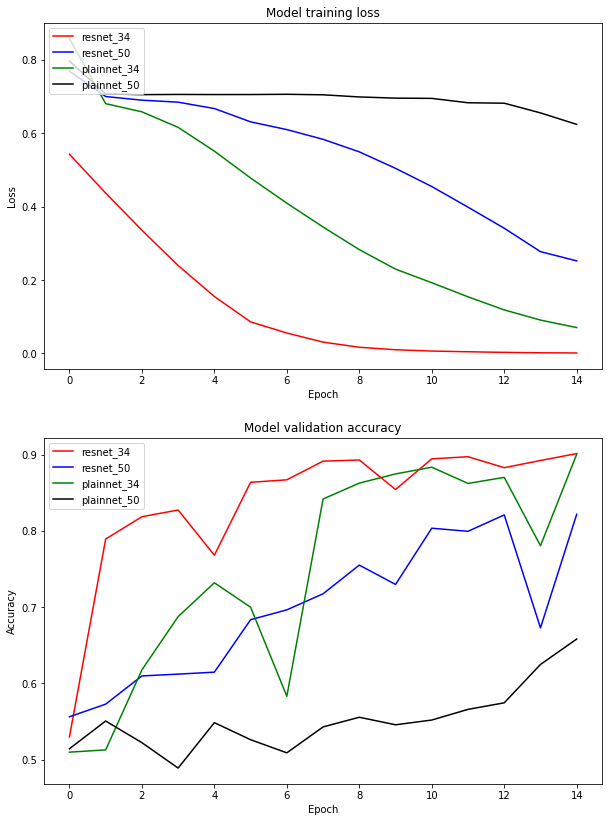

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,14))

plt.subplot(211)
plt.plot(hist_res_34.history['loss'], 'r')
plt.plot(hist_res_50.history['loss'], 'b')
plt.plot(hist_pln_34.history['loss'], 'g')
plt.plot(hist_pln_50.history['loss'], 'k')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50', 'plainnet_34', 'plainnet_50'], loc='upper left')

plt.subplot(212)
plt.plot(hist_res_34.history['val_accuracy'], 'r')
plt.plot(hist_res_50.history['val_accuracy'], 'b')
plt.plot(hist_pln_34.history['val_accuracy'], 'g')
plt.plot(hist_pln_50.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50', 'plainnet_34', 'plainnet_50'], loc='upper left')
plt.show()

### 그래프 분석
- 에폭수가 그렇게 크지 않아서 성능이 확실하게 나온지는 모르겠지만, 레이어가 적은 34 그룹이 선방한 모습을 보인다.
- 에폭수가 더 늘어난 후에 변동이 잡힌 추이를 보면 더 확인하기 좋을 것 같다.
- resnet이 plainnet에 비해서, 그리고 34 레이어가 50 레이어에 비해서 훈련 로스와 검증 정확도 측면에서 성능이 좋은 것을 확인할 수 있다.
- resnet이 plainnet에 비해서 성능이 좋은 것은 잔차 연결의 유무로 예측 가능했지만, 층이 깊을수록 학습이 잘될 것이라는 예상과는 다른 결과가 나왔다.
- 훈련 추이를 들여다봤을 때는 아직 과대 적합이 나타나지 않은 모습을 보인다. 그래서 오히려 변동성없이 좋은 성능에 수렴할 수 있을 것 같다는 생각이 드는데, 이는 훈련을 더 빠르게 진행할 수 있는 데이터 셋으로 확인해보는 것이 좋겠다.


### 회고
- 잔차 연결이 기울기 소멸 문제에 효과적이라는 것을 Ablation study를 통해 알 수 있었다.
- 층을 더 깊게했을 때 성능 차이는 조금 더 복잡한 문제에서 뚜렷하게 나타날 것 같다.
- 학습이 너무 오래 걸려서 다음 모델을 구현했을 때 학습 시간이 걱정된다.